# Aligning data to the Allen reference atlas using Landmarks

This tutorial shows how to access data from <[DANDI:00XXXX](https://dandiarchive.org/dandiset/00XXXX/draft)> for the IBL widefield dataset
and align data to the Allen reference atlas using Landmarks.

## Study Overview

[TODO add description]

## Contents

1. [Setup and Data Access](#setup)
2. [Temporal components](#temporal-components)
3. [Spatial components](#spatial-components)
4. [Summary images](#summary-images)
4. [Landmarks](#landmarks)
5. [Anatomical localization](#anatomical-coordinates)

---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [1]:
# Core data manipulation and analysis
# Visualization
import matplotlib.pyplot as plt

# NWB access
from pynwb import read_nwb
from skimage.transform import SimilarityTransform

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Read NWB file from local path

You can read the NWB file from a local path using `pynwb.read_nwb()`.

In [2]:
subject_id = "CSK-im-009"  # Example subject
session_id = "2864dca1-38d8-464c-9777-f6fdfd5e63b5"  # EID for the session

# Read NWB file from local path
nwbfile_path = f"/Volumes/T9/data/IBL/nwbfiles/sub-{subject_id}_ses-{session_id}_desc-processed_ophys+behavior.nwb"
nwbfile = read_nwb(nwbfile_path)

---

# 2. Temporal components <a id="temporal-compontents"></a>

The SVD temporal components are stored in the `ophys` processing module within the "SVDTemporalComponents" container.

Data shape
- Arrays are shaped `(time, num_components)` — the first dimension is time (frame), the second is the number of components.


Denoised/decomposed series names:
- Calcium (470 nm): `DenoisedSVDTemporalComponentsCalcium`
- Isosbestic (405 nm): `DenoisedSVDTemporalComponentsIsosbestic`
Haemodynamically corrected series name:
- Calcium (470 nm): `HaemoCorrectedSVDTemporalComponentsCalcium`

Access example
```python
SVD_temporal_components = nwbfile.processing["ophys"]["SVDTemporalComponents"]["DenoisedSVDTemporalComponentsCalcium"]
```

In [3]:
print(f"=== SVD Temporal components: ===")
print("-" * 100)
svd_module = nwbfile.processing["ophys"]["SVDTemporalComponents"]
for _, temporal_components in svd_module.roi_response_series.items():
    print(f"Trace: {temporal_components.name}")
    print("-" * 100)
    print(f"   Description: {temporal_components.description}")
    print(f"   Number of ROIs: {temporal_components.data.shape[1]}")
    print(f"   Duration: {temporal_components.timestamps[-1] - temporal_components.timestamps[0]:.2f} seconds")
    print("-" * 100)

=== SVD Temporal components: ===
----------------------------------------------------------------------------------------------------
Trace: DenoisedSVDTemporalComponentsCalcium
----------------------------------------------------------------------------------------------------
   Description: SVD temporal components (denoised/decomposed) of widefield calcium imaging from Blue light (470 nm) excitation.
   Number of ROIs: 200
   Duration: 4920.59 seconds
----------------------------------------------------------------------------------------------------
Trace: DenoisedSVDTemporalComponentsIsosbestic
----------------------------------------------------------------------------------------------------
   Description: SVD temporal components (denoised/decomposed) of widefield calcium imaging from Violet light (405 nm) excitation.
   Number of ROIs: 200
   Duration: 4920.59 seconds
----------------------------------------------------------------------------------------------------
Trace: Ha

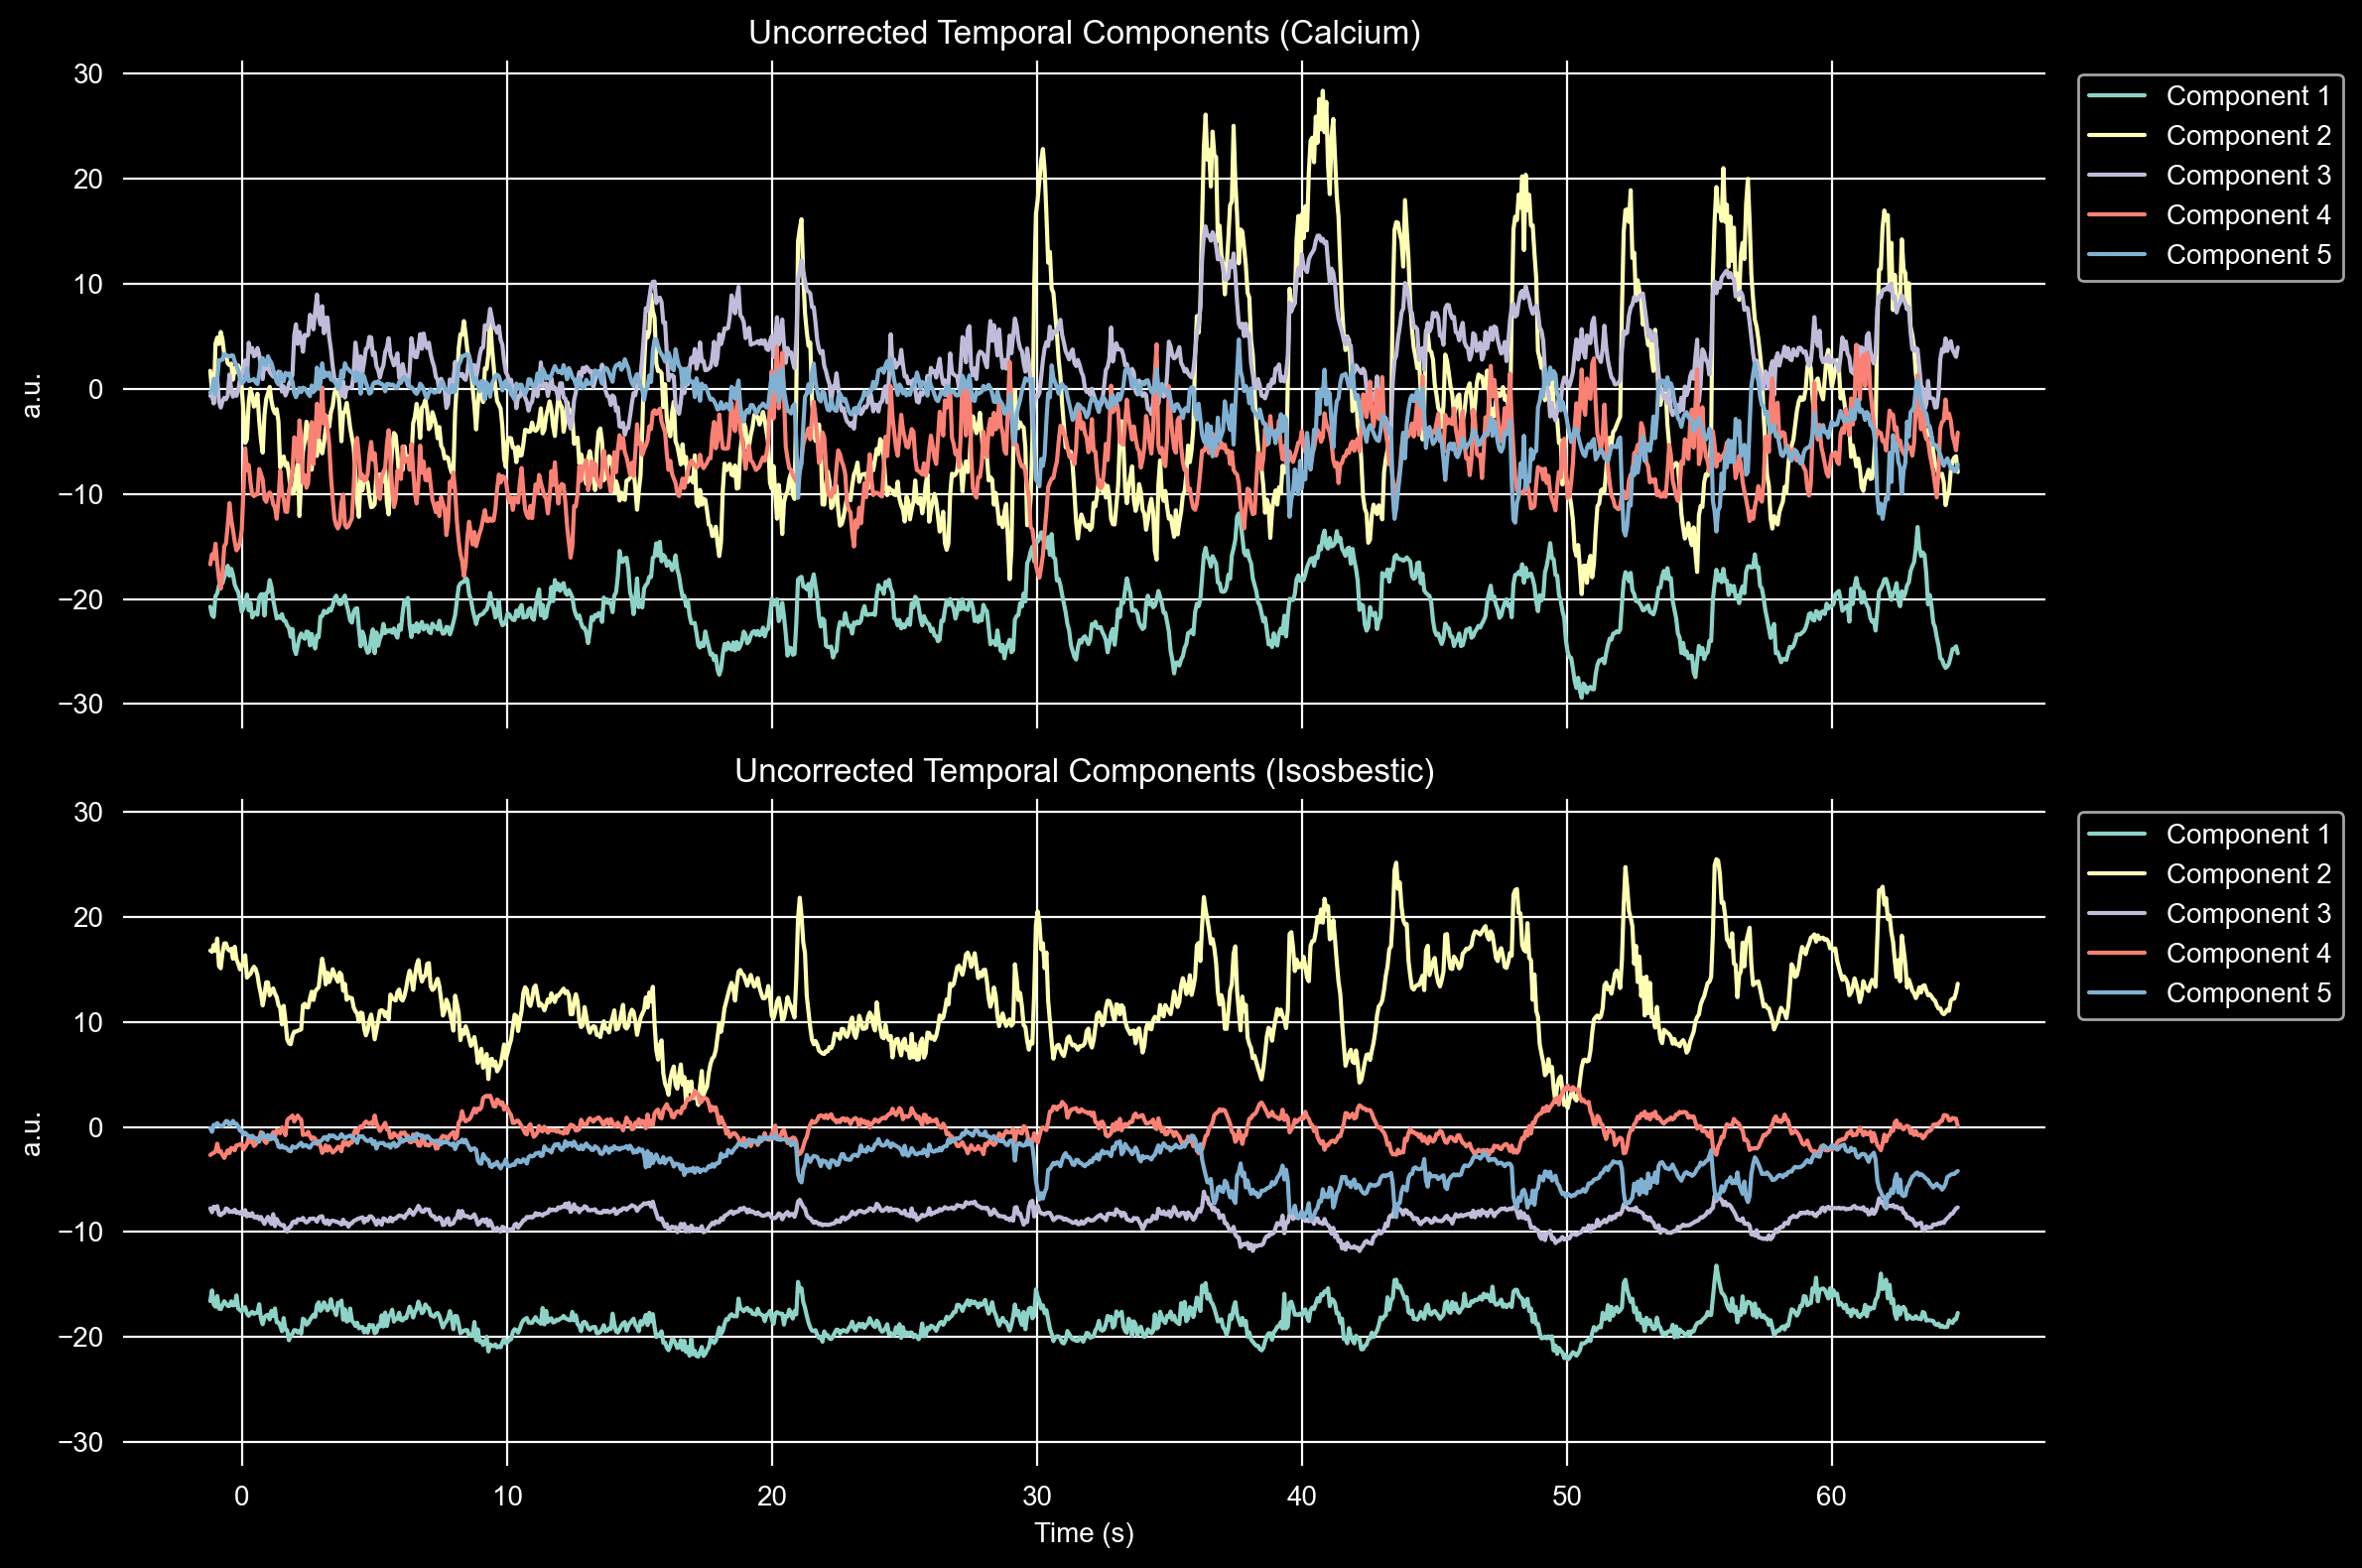

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True, sharey=True)

num_rois = 5
roi_response = svd_module.roi_response_series["DenoisedSVDTemporalComponentsCalcium"]
time = roi_response.timestamps[:1000]  # First 1000 time points
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[0].plot(time, roi_response.data[:1000, roi_idx], label=f'Component {roi_idx+1}')
ax[0].set_title('Uncorrected Temporal Components (Calcium)')
ax[0].set_ylabel('a.u.')
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[0].set_frame_on(False)

roi_response_iso = svd_module.roi_response_series["DenoisedSVDTemporalComponentsIsosbestic"]
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[1].plot(time, roi_response_iso.data[:1000, roi_idx], label=f'Component {roi_idx+1}')
ax[1].set_title('Uncorrected Temporal Components (Isosbestic)')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('a.u.')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].set_frame_on(False)
plt.tight_layout()

plt.show()

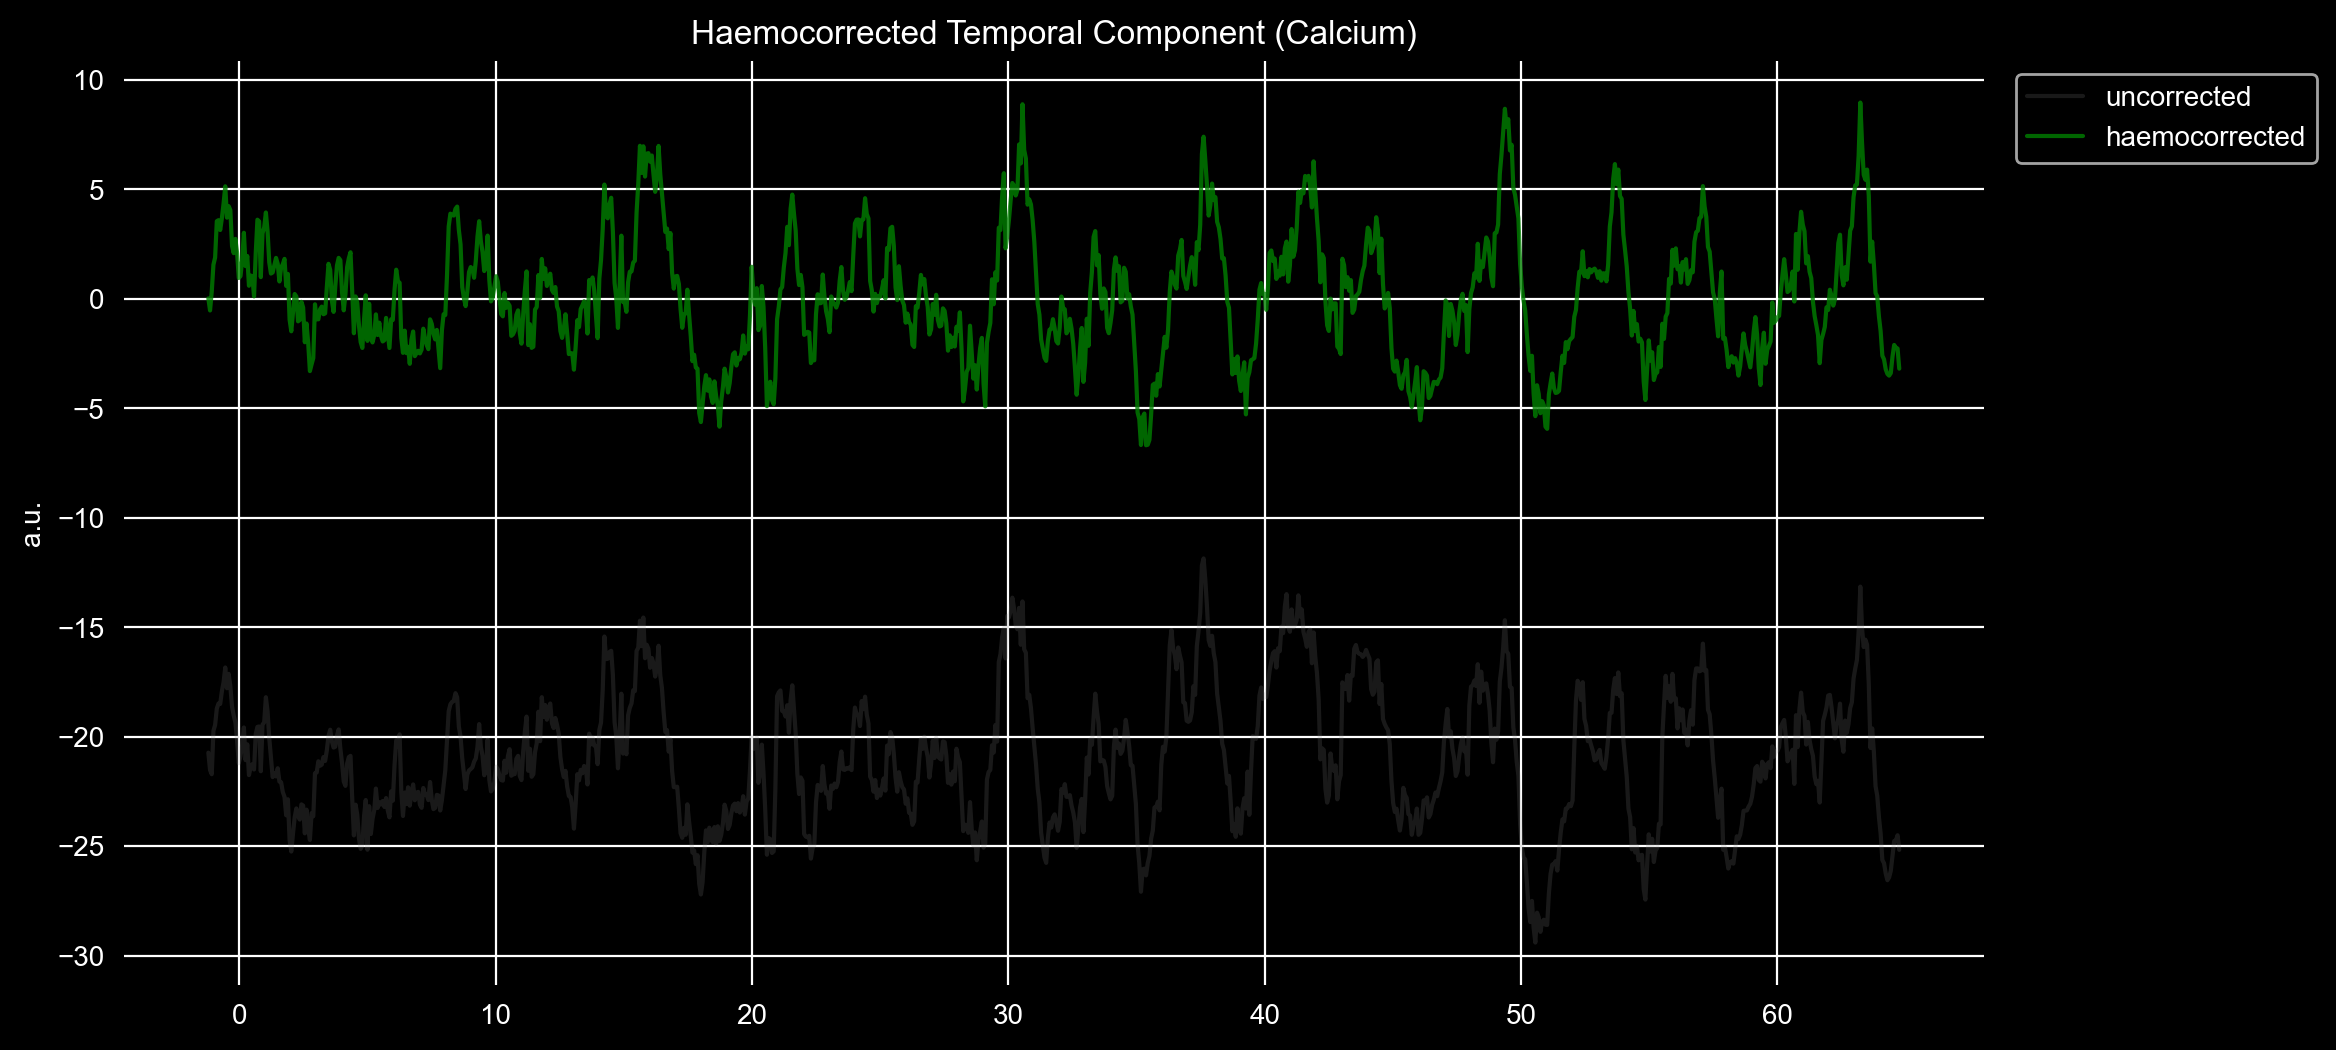

In [5]:
fig, ax = plt.subplots(dpi=200)

roi_response_dff = svd_module["HaemoCorrectedSVDTemporalComponentsCalcium"]
roi_response_raw = svd_module["DenoisedSVDTemporalComponentsCalcium"]

time = roi_response_raw.timestamps[:1000]  # First 1000 time points
ax.plot(time, roi_response_raw.data[:1000, 0], label="uncorrected", color="grey", alpha=0.2)
ax.plot(time, roi_response_dff.data[:1000, 0], label="haemocorrected", color="green", alpha=0.8)
ax.set_title('Haemocorrected Temporal Component (Calcium)')
ax.set_ylabel('a.u.')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_frame_on(False)

plt.show()

---

# 3. Spatial components <a id="spatial-compontents"></a>

The spatial components are stored in the `ophys` processing module within the "SVDSpatialComponents" container.

Data shape
- Arrays are shaped `(num_components, height, width)` — the first dimension is the number of components, the second and third are the image size (e.g. `(200, 540, 640)`)

Spatial components names:
- Calcium (470 nm): `SVDTemporalComponentsCalcium`
- Isosbestic (405 nm): `SVDTemporalComponentsIsosbestic`

Access example
```python
spatial_components = nwbfile.processing["ophys"]["SVDSpatialComponents"]["SVDTemporalComponentsCalcium"]
```

In [6]:
print(f"=== Spatial Components: ===")
print("-" * 100)
spatial_components_module = nwbfile.processing["ophys"]["SVDSpatialComponents"]
for _, plane_segmentation in spatial_components_module.plane_segmentations.items():
    print(f"Plane Segmentation: {plane_segmentation.name}")
    print("-" * 100)
    print(f"   Description: {plane_segmentation.description}")
    print(f"   Linked Imaging Plane: {plane_segmentation.imaging_plane.name}")
    print(f"   ROIs properties: {plane_segmentation.colnames}")
    print("-" * 100)

=== Spatial Components: ===
----------------------------------------------------------------------------------------------------
Plane Segmentation: SVDTemporalComponentsCalcium
----------------------------------------------------------------------------------------------------
   Description: Spatial components for widefield calcium imaging.
   Linked Imaging Plane: ImagingPlaneCalcium
   ROIs properties: ('roi_name', 'image_mask')
----------------------------------------------------------------------------------------------------
Plane Segmentation: SVDTemporalComponentsIsosbestic
----------------------------------------------------------------------------------------------------
   Description: Spatial components for widefield calcium imaging.
   Linked Imaging Plane: ImagingPlaneIsosbestic
   ROIs properties: ('roi_name', 'image_mask')
----------------------------------------------------------------------------------------------------


In [7]:
plane_segmentation = spatial_components_module["SVDTemporalComponentsCalcium"]
# view plane segmentation table
plane_segmentation.to_dataframe()

roi_name                                         image_mask
id                                                             
0          0  [[0.041995365, 0.03945256, 0.03720876, 0.03650...
1          1  [[-0.02643075, -0.015914066, -0.014987613, -0....
2          2  [[-0.0145443035, 0.009987158, 0.0079432465, 0....
3          3  [[-0.03683752, -0.0025825198, -0.0023083454, -...
4          4  [[-0.012025796, -0.0021518157, -0.0018589466, ...
..       ...                                                ...
195      195  [[0.018911257, 0.007712466, 0.04889216, 0.0266...
196      196  [[0.021622432, 0.012585476, 0.06765012, 0.0340...
197      197  [[0.01008541, 0.0077144112, 0.010999754, 0.012...
198      198  [[-0.013361225, 0.009262473, -0.035004184, -0....
199      199  [[0.003351193, 0.01011889, 0.016864907, 0.0098...

[200 rows x 2 columns]

In [8]:
plane_segmentation["image_mask"].shape

(200, 540, 640)

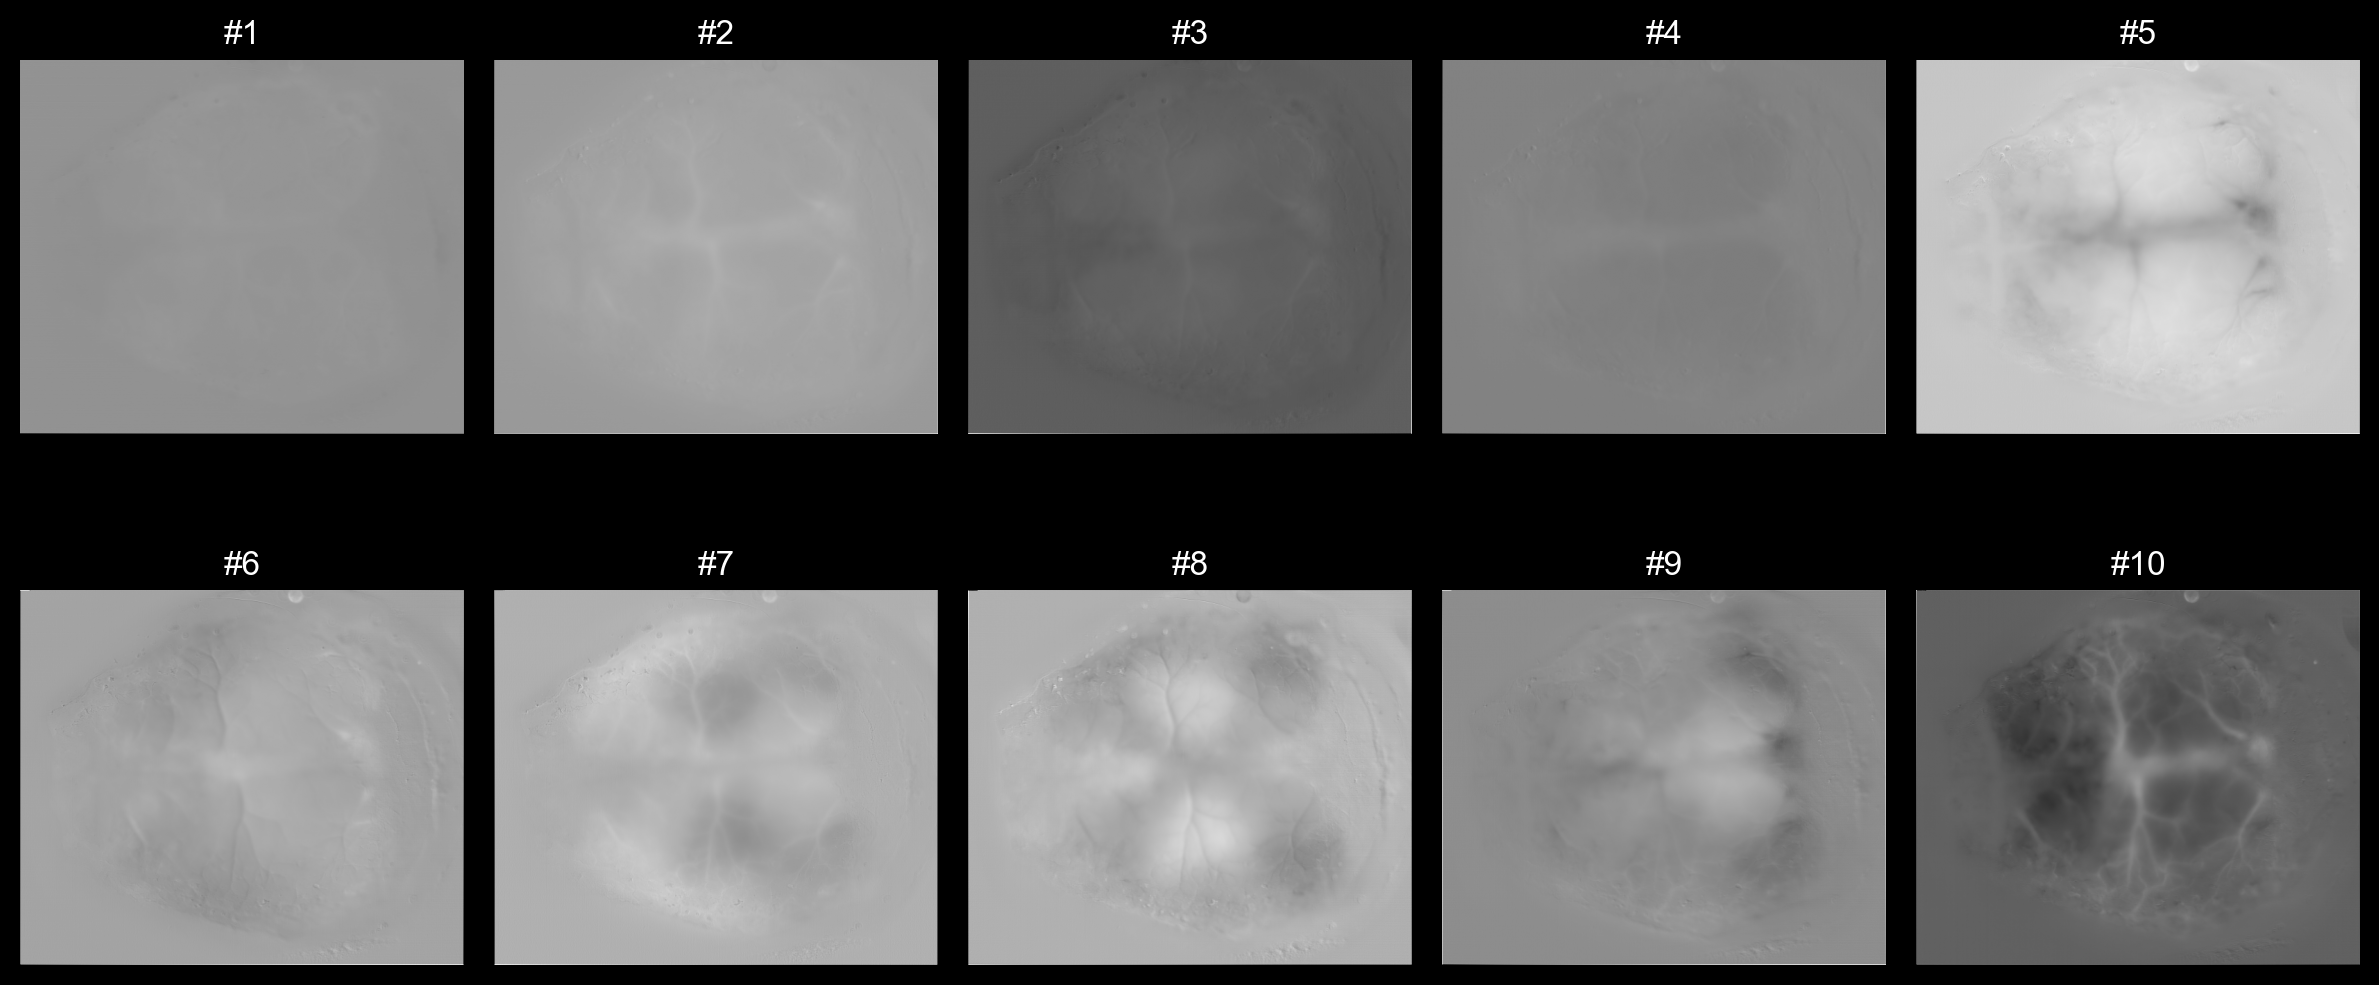

In [9]:
# view example spatial components
roi_ids = range(10)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, dpi=200)
for ax, roi_id in zip(axes.flatten(), roi_ids):
    ax.imshow(plane_segmentation["image_mask"][roi_id], cmap="gray")
    ax.set_title(f'#{roi_id + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

---

# 4. Summary images <a id="summary-images"></a>

The summary images are stored in GrayscaleImage objects in an Images container within the "ophys" processing module.

In [10]:
print(f"=== SUMMARY IMAGES: ===")
print("-" * 100)
summary_images = nwbfile.processing["ophys"]["SummaryImages"]
for _, summary_image in summary_images.images.items():
    print(f"Image: {summary_image.name}")
    print("-" * 100)
    print(f"   Description: {summary_image.description}")
    print(f"   Dimensions: {summary_image.data.shape}")
    print("-" * 100)

=== SUMMARY IMAGES: ===
----------------------------------------------------------------------------------------------------
Image: MeanImage
----------------------------------------------------------------------------------------------------
   Description: The mean image under Blue (470 nm) excitation across the imaging session. The dimensions are (height, width).
   Dimensions: (540, 640)
----------------------------------------------------------------------------------------------------
Image: MeanImageIsosbestic
----------------------------------------------------------------------------------------------------
   Description: The mean image under Violet (405 nm) excitation across the imaging session. The dimensions are (height, width).
   Dimensions: (540, 640)
----------------------------------------------------------------------------------------------------


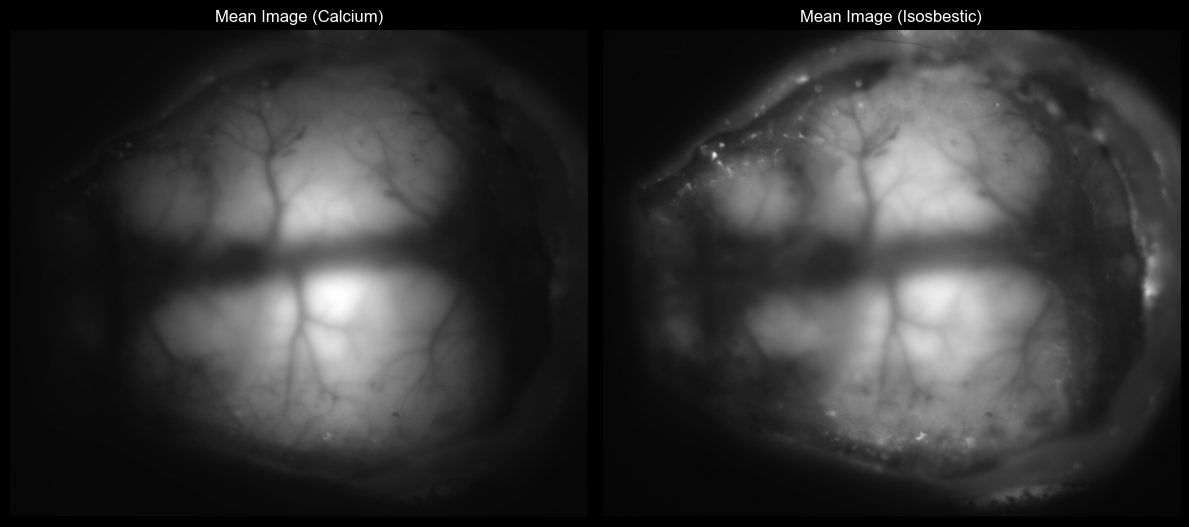

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

mean_image = summary_images.images["MeanImage"]
axes[0].imshow(mean_image, cmap="gray")
axes[0].set_title('Mean Image (Calcium)')
axes[0].axis('off')

mean_image_isosbestic = summary_images.images["MeanImageIsosbestic"]
axes[1].imshow(mean_image_isosbestic, cmap="gray")
axes[1].set_title('Mean Image (Isosbestic)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Aligning data to the Allen reference atlas using Landmarks <a id="landmarks"></a>

The imaging stack can be reconstructed from the decomposed spatial and temporal components of the SVD. The imaging stack contains the imaging data for each frame in the session and has dimensions (time, height, width).

In [12]:
spatial_transformation_metadata = nwbfile.lab_meta_data["SpatialTransformationMetadata"]
spatial_transformation_metadata

SpatialTransformationMetadata abc.SpatialTransformationMetadata at 0x5595779136
Fields:
  landmarks: {
    Landmarks <class 'abc.Landmarks'>
  }
  spatial_transformations: {
    AffineTransformation <class 'abc.AffineTransformation'>
  }

In [13]:
affine_transformation = spatial_transformation_metadata.spatial_transformations["AffineTransformation"]

print("=== Transform ===")
print("-" * 100)
print(f"Source Image: {summary_images.images["MeanImage"].name}")
print("-" * 100)
print(f"   Affine matrix (3x3): ")
for i in range(3):
    print(f"   [{affine_transformation.affine_matrix[i,0]: .4f}  {affine_transformation.affine_matrix[i,1]: .4f} {affine_transformation.affine_matrix[i,2]: .4f}]")


=== Transform ===
----------------------------------------------------------------------------------------------------
Source Image: MeanImage
----------------------------------------------------------------------------------------------------
   Affine matrix (3x3): 
   [-0.1192   0.9668  68.2827]
   [-0.9668  -0.1192  597.9486]
   [ 0.0000   0.0000  1.0000]


In [14]:
landmarks = spatial_transformation_metadata.landmarks["Landmarks"]
landmarks[:]

source_coordinates  \
id                                             
0   [122.82823662400486, 374.74061431319194]   
1     [130.7224452901809, 277.0783289856377]   
2   [103.60828359278639, 182.37820391119132]   
3    [451.2174988958829, 235.36114715363922]   

                         target_coordinates landmark_labels    color  \
id                                                                     
0   [219.48453608247422, 92.16494845360825]         OB_left  #fc9d03   
1                [320.0, 92.16494845360825]       OB_center  #0367fc   
2    [420.5154639175258, 92.16494845360825]        OB_right  #fc9d03   
3                [320.0, 434.9484536082474]        RSP_base  #fc4103   

   bregma_offset  resolution  
id                            
0     [320, 270]        19.4  
1     [320, 270]        19.4  
2     [320, 270]        19.4  
3     [320, 270]        19.4

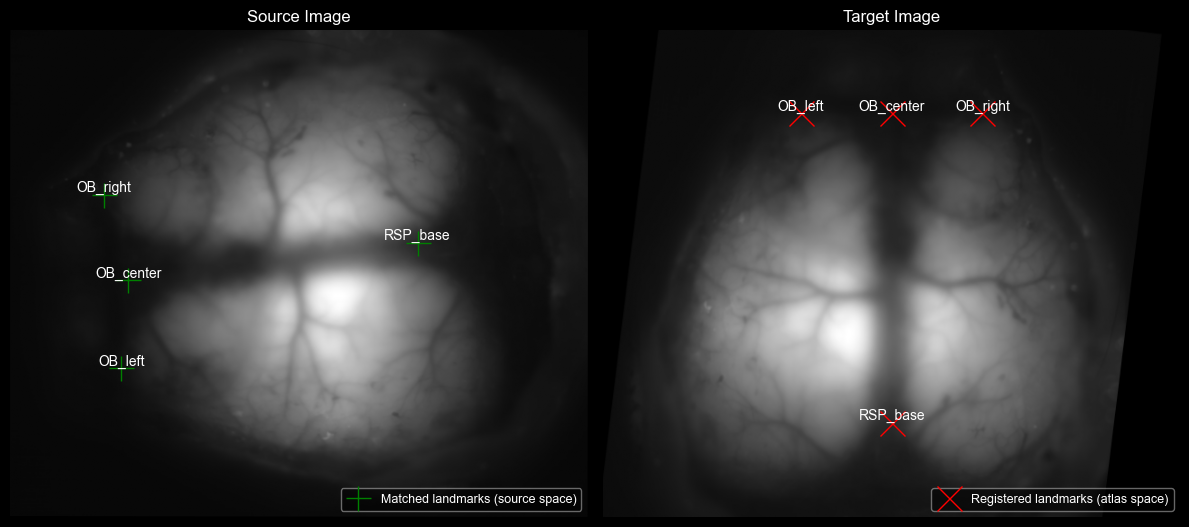

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)


landmarks_df = landmarks[:]
mean_image = summary_images.images["MeanImage"]
mean_image_transformed = nwbfile.processing["ophys"]["TransformedImages"]["TransformedMeanImage"].data[:]

axes[0].imshow(mean_image.data[:], cmap="gray")
axes[0].set_title('Source Image')
axes[0].axis('off')

axes[0].plot(
    landmarks_df["source_coordinates"].apply(lambda v: v[0]),
    landmarks_df["source_coordinates"].apply(lambda v: v[1]),
    "g+",
    ms=18,
    label="Matched landmarks (source space)",
)

# label each source point
for _, row in landmarks_df.iterrows():
    axes[0].text(
        row["source_coordinates"][0],
        row["source_coordinates"][1],
        row["landmark_labels"],
        color="w",
        va="bottom",
        ha="center",
    )

axes[1].imshow(mean_image_transformed, cmap="gray")
axes[1].set_title('Target Image')
axes[1].axis('off')

axes[1].plot(
    landmarks_df["target_coordinates"].apply(lambda v: v[0]),
    landmarks_df["target_coordinates"].apply(lambda v: v[1]),
    "rx",
    ms=18,
    label="Registered landmarks (atlas space)",
)

for _, row in landmarks_df.iterrows():
    axes[1].text(
        row["target_coordinates"][0],
        row["target_coordinates"][1],
        row["landmark_labels"],
        color="w",
        va="bottom",
        ha="center",
    )

# --- Legends and annotation ---
axes[0].legend(loc="lower right", fontsize=9, frameon=True, facecolor="black", framealpha=0.5)
axes[1].legend(loc="lower right", fontsize=9, frameon=True, facecolor="black", framealpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave room for subtitle
plt.show()

The imaging stack can be reconstructed from the decomposed spatial and temporal components of the SVD.
The imaging stack contains the imaging data for each frame in the session and has dimensions (nFrames, nx, ny) where nx is the width of the imaging window, and ny the height.

In [16]:
import numpy as np
import wfield

# Spatial components (U):
# plane_segmentation["image_mask"].data has shape: (num_rois, height, width)
U = plane_segmentation["image_mask"].data[:]          # (n_components, height, width)
print(f"Spatial components U shape (n_components, height, width): {U.shape}")

# Haemocorrected temporal components (SVT):
# roi_response_dff.data has shape: (time, num_rois)
SVT = roi_response_dff.data[:]                        # (time, n_components)
print(f"Temporal components SVT shape (time, n_components): {SVT.shape}")

# --- Prepare shapes for SVDStack ---

# wfield.SVDStack expects:
#   U_stack:  (height, width, n_components)
#   SVT_stack: (n_components, time)
U_stack = np.transpose(U, (1, 2, 0))                  # (height, width, n_components)
SVT_stack = SVT.T                                     # (n_components, time)

print(f"U_stack shape (height, width, n_components): {U_stack.shape}")
print(f"SVT_stack shape (n_components, time):         {SVT_stack.shape}")

# --- Build the reconstructed imaging stack ---
# Resulting stack has shape: (time, height, width)
stack = wfield.SVDStack(U_stack, SVT_stack)
print(f"Reconstructed stack shape (time, height, width): {stack.shape}")

Spatial components U shape (n_components, height, width): (200, 540, 640)
Temporal components SVT shape (time, n_components): (74531, 200)
U_stack shape (height, width, n_components): (540, 640, 200)
SVT_stack shape (n_components, time):         (200, 74531)
Reconstructed stack shape (time, height, width): [74531, 540, 640]


In [17]:
# Warp and register the image stack to the Allen dorsal
from skimage.transform import SimilarityTransform

M = SimilarityTransform(affine_transformation.affine_matrix)
stack.set_warped(True, M=M)

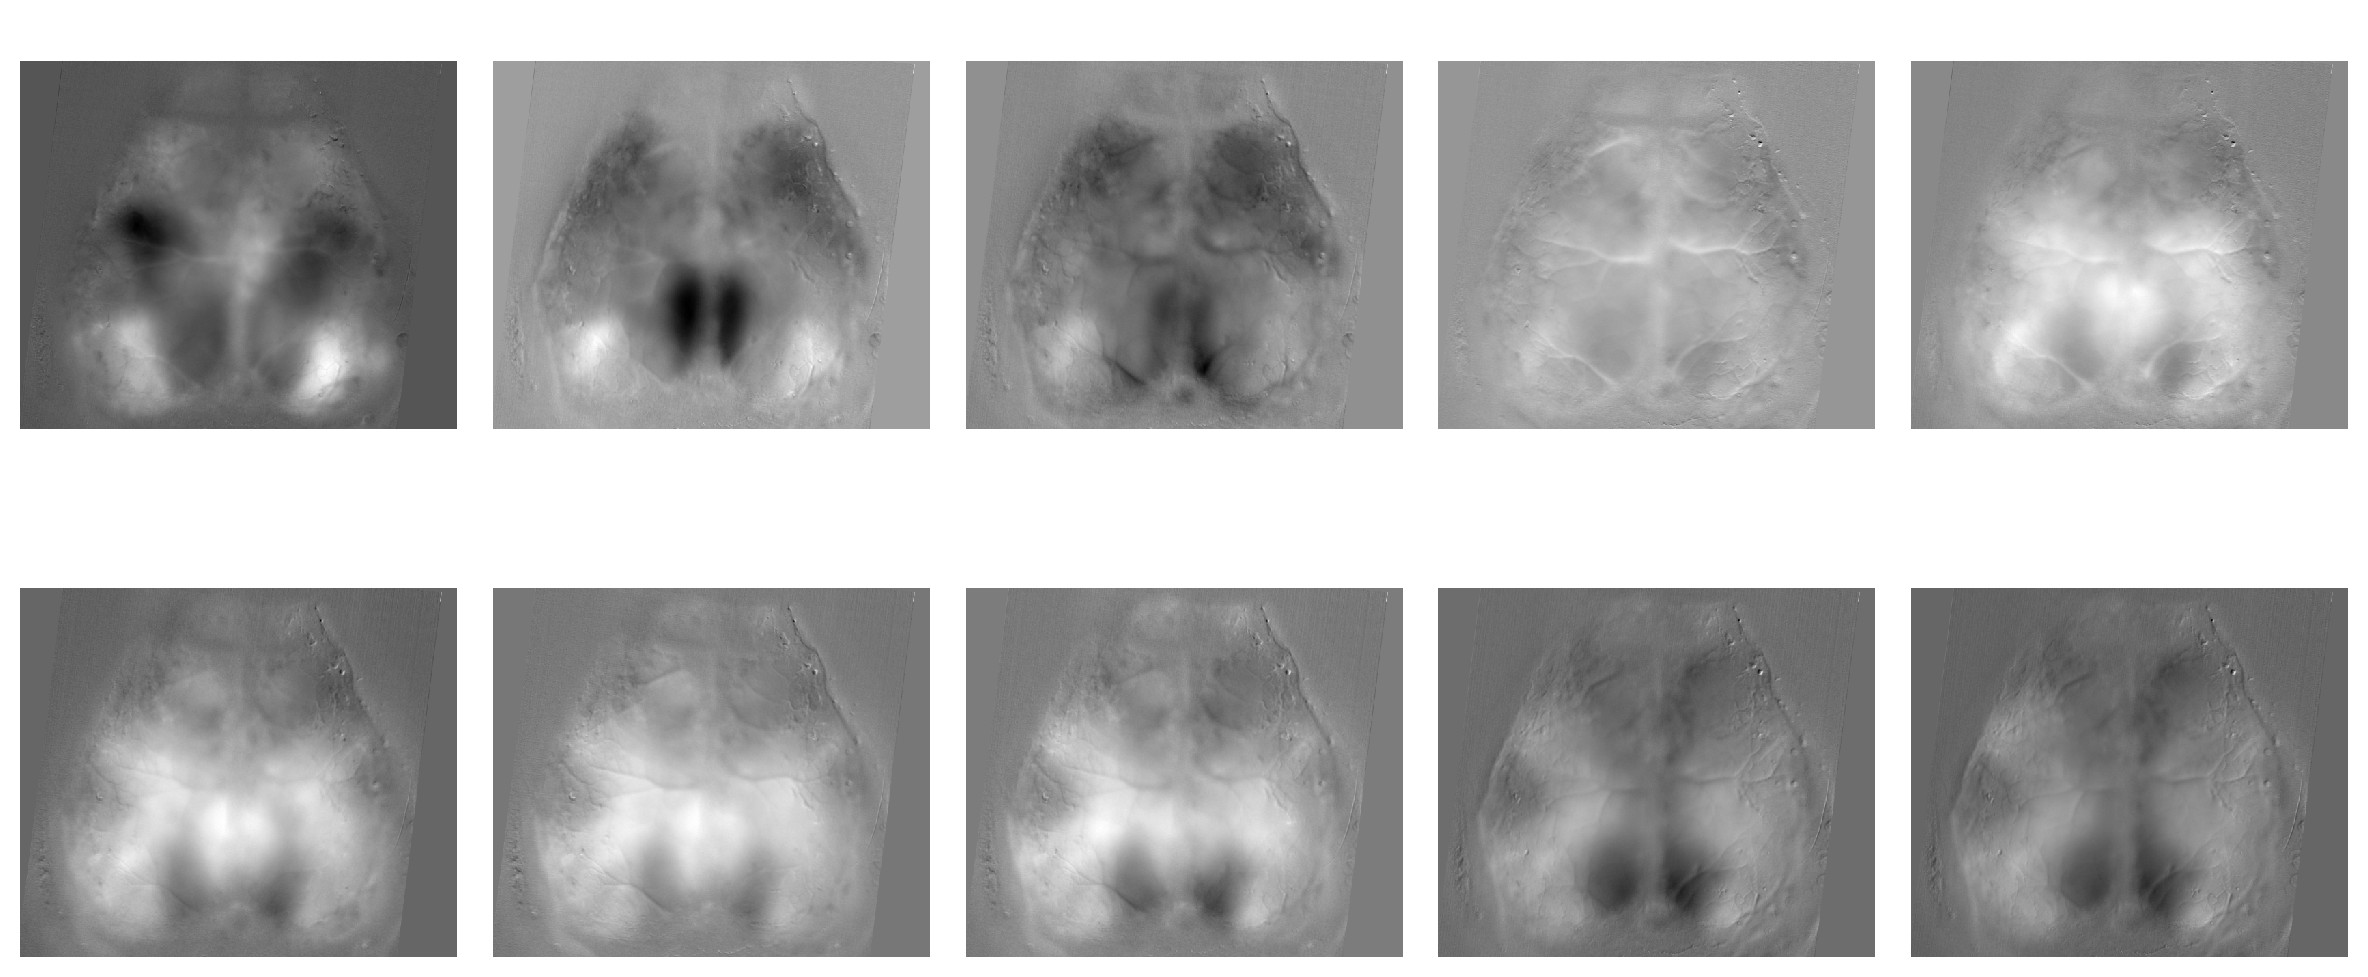

In [18]:
frames = range(10)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, dpi=200)

for ax, frame_ind in zip(axes.flatten(), frames):
    ax.imshow(stack[frame_ind], cmap="gray")
    ax.set_title(f"WarpedImageStack#{frame_ind}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

---

# 5. Anatomical localization <a id="anatomical-coordinates"></a>



In [19]:
# IBL Bregma-centered coordinates (um) of landmarks. Coordinates are in um in the IBL frame (RAS: x=ML, y=AP, z=DV).
ibl_bregma_table = nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables["AnatomicalCoordinatesIBLBregma"]
ibl_bregma_table[:]

x       y    z  localized_entity brain_region
id                                                    
0  -1950.0 -3450.0  0.0                 0      OB_left
1      0.0 -3450.0  0.0                 1    OB_center
2   1950.0 -3450.0  0.0                 2     OB_right
3      0.0  3200.0  0.0                 3     RSP_base

In [20]:
# The anatomical coordinates table references the landmarks table
ibl_bregma_table.localized_entity

localized_entity hdmf.common.table.DynamicTableRegion at 0x5621658640
    Target table: Landmarks abc.Landmarks at 0x5599455680

In [21]:
# CCF coordinates (um) of landmarks. Coordinates are in the native Allen CCF format with PIR+ orientation (x=AP, y=DV, z=ML).
allen_ccf_table = nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables["AnatomicalCoordinatesCCFv3"]
allen_ccf_table[:]

x      y       z  localized_entity brain_region
id                                                      
0   8850.0  332.0  3789.0                 0      OB_left
1   8850.0  332.0  5739.0                 1    OB_center
2   8850.0  332.0  7689.0                 2     OB_right
3   2200.0  332.0  5739.0                 3     RSP_base

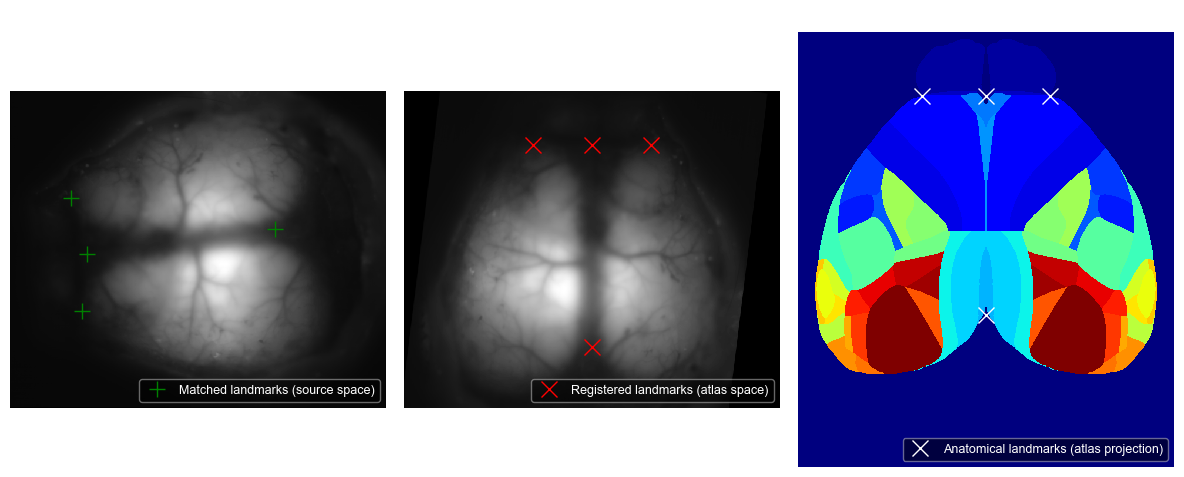

In [22]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

landmarks_df = landmarks[:]
mean_image = summary_images.images["MeanImage"]
mean_image_transformed = nwbfile.processing["ophys"]["TransformedImages"]["TransformedMeanImage"].data[:]

axes[0].imshow(mean_image.data[:], cmap="gray")
axes[0].set_title('Source Image')
axes[0].axis('off')

axes[0].plot(
    landmarks_df["source_coordinates"].apply(lambda v: v[0]),
    landmarks_df["source_coordinates"].apply(lambda v: v[1]),
    "g+",
    ms=12,
    label="Matched landmarks (source space)",
)

axes[1].imshow(mean_image_transformed, cmap="gray")
axes[1].set_title('Target Image')
axes[1].axis('off')

axes[1].plot(
    landmarks_df["target_coordinates"].apply(lambda v: v[0]),
    landmarks_df["target_coordinates"].apply(lambda v: v[1]),
    "rx",
    ms=12,
    label="Registered landmarks (atlas space)",
)

# Location of landmarks in reference image
# These values are hardcoded in the wfield package and assume bregma is at (540, 570)
# See code here https://github.com/jcouto/wfield/blob/master/wfield/allen.py#L136

proj = nwbfile.processing["ophys"]["AtlasProjectionImages"]["AtlasProjectionImage"].data[:]

axes[2].imshow(proj, cmap="jet")
axes[2].plot(
    ibl_bregma_table["x"][:] /10 + 570.0,  # adjust for offset in dorsal cortex reference,
    ibl_bregma_table["y"][:] /10 + 540.0,  # adjust for offset in dorsal cortex reference,
    "wx",
    ms=12,
    label="Anatomical landmarks (atlas projection)",
)
axes[2].set_title('Atlas projection')
axes[2].axis("off")


# --- Legends and annotation ---
axes[0].legend(loc="lower right", fontsize=9, frameon=True, facecolor="black", framealpha=0.5)
axes[1].legend(loc="lower right", fontsize=9, frameon=True, facecolor="black", framealpha=0.5)
axes[2].legend(loc="lower right", fontsize=9, frameon=True, facecolor="black", framealpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave room for subtitle
plt.show()

---

# 6. CCF Regions <a id="ccf"></a>

CCF regions tables are added to `nwbfile.lab_meta_data` in a container `IblWidefieldCCFRegionsMetadata` that holds the CCF regions tables with the coordinates in atlas, source, or transformed/warped space.

- CCF regions in atlas/reference space:  `nwbfile.lab_meta_data["ibl_ccf_regions"]["ccf_regions_atlas"]`
- in source/original space: `nwbfile.lab_meta_data["ibl_ccf_regions"]["ccf_regions_source"]`
- in target/warped space: `nwbfile.lab_meta_data["ibl_ccf_regions"]["ccf_regions_target"]`

The 2D atlas projection is stored as a GrayScaleImage added to `nwbfile.processing["ophys"]["AtlasProjectionImages"]` images container.

In [23]:
ibl_ccf_regions = nwbfile.lab_meta_data["ibl_ccf_regions"]
ibl_ccf_regions

ibl_ccf_regions abc.IblWidefieldCCFRegionsMetadata at 0x5595783168
Fields:
  ibl_widefield_ccf_regions_tables: {
    ccf_regions_atlas <class 'abc.IblWidefieldCCFRegionsTable'>,
    ccf_regions_source <class 'abc.IblWidefieldCCFRegionsTable'>,
    ccf_regions_target <class 'abc.IblWidefieldCCFRegionsTable'>
  }
  projection_image: AtlasProjectionImage <class 'pynwb.image.GrayscaleImage'>

In [24]:
# CCF regions in atlas projection space
ibl_ccf_regions["ccf_regions_atlas"][:]

acronym                                brain_region   bregma_offset label  \
id                                                                              
0       MOB                         Main olfactory bulb  [540.0, 570.0]     1   
1       FRP               Frontal pole, cerebral cortex  [540.0, 570.0]     2   
2       MOp                          Primary motor area  [540.0, 570.0]     3   
3       MOs                        Secondary motor area  [540.0, 570.0]     4   
4     SSp-n            Primary somatosensory area, nose  [540.0, 570.0]     5   
5     SSp-m           Primary somatosensory area, mouth  [540.0, 570.0]     6   
6    SSp-un      Primary somatosensory area, unassigned  [540.0, 570.0]     7   
7        PL                              Prelimbic area  [540.0, 570.0]     8   
8      ACAd        Anterior cingulate area, dorsal part  [540.0, 570.0]     9   
9      RSPv            Retrosplenial area, ventral part  [540.0, 570.0]    10   
10     RSPd             Retrosplenial area, dorsal part  [540.0, 570.0]    11   
11   RSPagl  Retrosplenial area, lateral agranular part  [540.0, 570.0]    12   
12     VISC                               Visceral area  [540.0, 570.0]    13   
13      SSs             Supplemental somatosensory area  [540.0, 570.0]    14   
14  SSp-bfd    Primary somatosensory area, barrel field  [540.0, 570.0]    15   
15   SSp-tr           Primary somatosensory area, trunk  [540.0, 570.0]    16   
16   SSp-ll      Primary somatosensory area, lower limb  [540.0, 570.0]    17   
17   SSp-ul      Primary somatosensory area, upper limb  [540.0, 570.0]    18   
18      TEa                  Temporal association areas  [540.0, 570.0]    19   
19     AUDd                        Dorsal auditory area  [540.0, 570.0]    20   
20     AUDp                       Primary auditory area  [540.0, 570.0]    21   
21    AUDpo                     Posterior auditory area  [540.0, 570.0]    22   
22     AUDv                       Ventral auditory area  [540.0, 570.0]    23   
23    VISli                     Laterointermediate area  [540.0, 570.0]    24   
24   VISpor                             Postrhinal area  [540.0, 570.0]    25   
25    VISpl                  Posterolateral visual area  [540.0, 570.0]    26   
26    VISpm                   posteromedial visual area  [540.0, 570.0]    27   
27     VISl                         Lateral visual area  [540.0, 570.0]    28   
28    VISal                   Anterolateral visual area  [540.0, 570.0]    29   
29    VISrl                   Rostrolateral visual area  [540.0, 570.0]    30   
30     VISa                               Anterior area  [540.0, 570.0]    31   
31    VISam                    Anteromedial visual area  [540.0, 570.0]    32   
32     VISp                         Primary visual area  [540.0, 570.0]    33   

     allen_id              allen_rgb                           left_center  \
id                                                                           
0         507  [154.0, 210.0, 189.0]        [-1.0204336826, -4.2703367543]   
1         184    [38.0, 143.0, 69.0]        [-0.9698151951, -3.5235934292]   
2         985    [31.0, 157.0, 90.0]        [-2.1104203178, -1.0662226896]   
3         993    [31.0, 157.0, 90.0]        [-1.1233387919, -1.8385300769]   
4         353   [24.0, 128.0, 100.0]         [-3.9726763679, 0.0650291036]   
5         345   [24.0, 128.0, 100.0]        [-3.7070809748, -0.9631218553]   
6   182305689   [24.0, 128.0, 100.0]         [-3.0603176568, 0.2960726073]   
7         972    [47.0, 168.0, 80.0]        [-0.2877936366, -3.1709991079]   
8          39   [64.0, 166.0, 102.0]        [-0.0891345566, -1.7320550459]   
9         886   [26.0, 166.0, 152.0]  [-0.10775991430000001, 2.3500884244]   
10        879   [26.0, 166.0, 152.0]         [-0.5757620033, 2.2768468827]   
11        894   [26.0, 166.0, 152.0]         [-1.1434841658, 2.5833824665]   
12        677   [17.0, 173.0, 131.0]         [-5.0248837209, 1.1794573643]  

In [26]:
# CCF regions in source/image space
ibl_ccf_regions["ccf_regions_source"][:]

acronym                                brain_region   bregma_offset label  \
id                                                                              
0       MOB                         Main olfactory bulb  [540.0, 570.0]     1   
1       FRP               Frontal pole, cerebral cortex  [540.0, 570.0]     2   
2       MOp                          Primary motor area  [540.0, 570.0]     3   
3       MOs                        Secondary motor area  [540.0, 570.0]     4   
4     SSp-n            Primary somatosensory area, nose  [540.0, 570.0]     5   
5     SSp-m           Primary somatosensory area, mouth  [540.0, 570.0]     6   
6    SSp-un      Primary somatosensory area, unassigned  [540.0, 570.0]     7   
7        PL                              Prelimbic area  [540.0, 570.0]     8   
8      ACAd        Anterior cingulate area, dorsal part  [540.0, 570.0]     9   
9      RSPv            Retrosplenial area, ventral part  [540.0, 570.0]    10   
10     RSPd             Retrosplenial area, dorsal part  [540.0, 570.0]    11   
11   RSPagl  Retrosplenial area, lateral agranular part  [540.0, 570.0]    12   
12     VISC                               Visceral area  [540.0, 570.0]    13   
13      SSs             Supplemental somatosensory area  [540.0, 570.0]    14   
14  SSp-bfd    Primary somatosensory area, barrel field  [540.0, 570.0]    15   
15   SSp-tr           Primary somatosensory area, trunk  [540.0, 570.0]    16   
16   SSp-ll      Primary somatosensory area, lower limb  [540.0, 570.0]    17   
17   SSp-ul      Primary somatosensory area, upper limb  [540.0, 570.0]    18   
18      TEa                  Temporal association areas  [540.0, 570.0]    19   
19     AUDd                        Dorsal auditory area  [540.0, 570.0]    20   
20     AUDp                       Primary auditory area  [540.0, 570.0]    21   
21    AUDpo                     Posterior auditory area  [540.0, 570.0]    22   
22     AUDv                       Ventral auditory area  [540.0, 570.0]    23   
23    VISli                     Laterointermediate area  [540.0, 570.0]    24   
24   VISpor                             Postrhinal area  [540.0, 570.0]    25   
25    VISpl                  Posterolateral visual area  [540.0, 570.0]    26   
26    VISpm                   posteromedial visual area  [540.0, 570.0]    27   
27     VISl                         Lateral visual area  [540.0, 570.0]    28   
28    VISal                   Anterolateral visual area  [540.0, 570.0]    29   
29    VISrl                   Rostrolateral visual area  [540.0, 570.0]    30   
30     VISa                               Anterior area  [540.0, 570.0]    31   
31    VISam                    Anteromedial visual area  [540.0, 570.0]    32   
32     VISp                         Primary visual area  [540.0, 570.0]    33   

     allen_id              allen_rgb  \
id                                     
0         507  [154.0, 210.0, 189.0]   
1         184    [38.0, 143.0, 69.0]   
2         985    [31.0, 157.0, 90.0]   
3         993    [31.0, 157.0, 90.0]   
4         353   [24.0, 128.0, 100.0]   
5         345   [24.0, 128.0, 100.0]   
6   182305689   [24.0, 128.0, 100.0]   
7         972    [47.0, 168.0, 80.0]   
8          39   [64.0, 166.0, 102.0]   
9         886   [26.0, 166.0, 152.0]   
10        879   [26.0, 166.0, 152.0]   
11        894   [26.0, 166.0, 152.0]   
12        677   [17.0, 173.0, 131.0]   
13        378   [24.0, 128.0, 100.0]   
14        329   [24.0, 128.0, 100.0]   
15        361   [24.0, 128.0, 100.0]   
16        337   [24.0, 128.0, 100.0]   
17        369   [24.0, 128.0, 100.0]   
18        541   [21.0, 176.0, 179.0]   
19       1011    [1.0, 147.0, 153.0]   
20       1002    [1.0, 147.0, 153.0]   
21       1027    [1.0, 147.0, 153.0]   
22       1018    [1.0, 147.0, 153.0]   
23  312782574    [8.0, 133.0, 140.0]   
24  312782628    [8.0, 133.0, 140.0]   
25        425    [8.0, 133.0, 140.0]   
26        533    [8.0, 133.0, 140.0]   
27      

In [27]:
# CCF regions in target/warped space
ibl_ccf_regions["ccf_regions_target"][:]

acronym                                brain_region   bregma_offset label  \
id                                                                              
0       MOB                         Main olfactory bulb  [540.0, 570.0]     1   
1       FRP               Frontal pole, cerebral cortex  [540.0, 570.0]     2   
2       MOp                          Primary motor area  [540.0, 570.0]     3   
3       MOs                        Secondary motor area  [540.0, 570.0]     4   
4     SSp-n            Primary somatosensory area, nose  [540.0, 570.0]     5   
5     SSp-m           Primary somatosensory area, mouth  [540.0, 570.0]     6   
6    SSp-un      Primary somatosensory area, unassigned  [540.0, 570.0]     7   
7        PL                              Prelimbic area  [540.0, 570.0]     8   
8      ACAd        Anterior cingulate area, dorsal part  [540.0, 570.0]     9   
9      RSPv            Retrosplenial area, ventral part  [540.0, 570.0]    10   
10     RSPd             Retrosplenial area, dorsal part  [540.0, 570.0]    11   
11   RSPagl  Retrosplenial area, lateral agranular part  [540.0, 570.0]    12   
12     VISC                               Visceral area  [540.0, 570.0]    13   
13      SSs             Supplemental somatosensory area  [540.0, 570.0]    14   
14  SSp-bfd    Primary somatosensory area, barrel field  [540.0, 570.0]    15   
15   SSp-tr           Primary somatosensory area, trunk  [540.0, 570.0]    16   
16   SSp-ll      Primary somatosensory area, lower limb  [540.0, 570.0]    17   
17   SSp-ul      Primary somatosensory area, upper limb  [540.0, 570.0]    18   
18      TEa                  Temporal association areas  [540.0, 570.0]    19   
19     AUDd                        Dorsal auditory area  [540.0, 570.0]    20   
20     AUDp                       Primary auditory area  [540.0, 570.0]    21   
21    AUDpo                     Posterior auditory area  [540.0, 570.0]    22   
22     AUDv                       Ventral auditory area  [540.0, 570.0]    23   
23    VISli                     Laterointermediate area  [540.0, 570.0]    24   
24   VISpor                             Postrhinal area  [540.0, 570.0]    25   
25    VISpl                  Posterolateral visual area  [540.0, 570.0]    26   
26    VISpm                   posteromedial visual area  [540.0, 570.0]    27   
27     VISl                         Lateral visual area  [540.0, 570.0]    28   
28    VISal                   Anterolateral visual area  [540.0, 570.0]    29   
29    VISrl                   Rostrolateral visual area  [540.0, 570.0]    30   
30     VISa                               Anterior area  [540.0, 570.0]    31   
31    VISam                    Anteromedial visual area  [540.0, 570.0]    32   
32     VISp                         Primary visual area  [540.0, 570.0]    33   

     allen_id              allen_rgb  \
id                                     
0         507  [154.0, 210.0, 189.0]   
1         184    [38.0, 143.0, 69.0]   
2         985    [31.0, 157.0, 90.0]   
3         993    [31.0, 157.0, 90.0]   
4         353   [24.0, 128.0, 100.0]   
5         345   [24.0, 128.0, 100.0]   
6   182305689   [24.0, 128.0, 100.0]   
7         972    [47.0, 168.0, 80.0]   
8          39   [64.0, 166.0, 102.0]   
9         886   [26.0, 166.0, 152.0]   
10        879   [26.0, 166.0, 152.0]   
11        894   [26.0, 166.0, 152.0]   
12        677   [17.0, 173.0, 131.0]   
13        378   [24.0, 128.0, 100.0]   
14        329   [24.0, 128.0, 100.0]   
15        361   [24.0, 128.0, 100.0]   
16        337   [24.0, 128.0, 100.0]   
17        369   [24.0, 128.0, 100.0]   
18        541   [21.0, 176.0, 179.0]   
19       1011    [1.0, 147.0, 153.0]   
20       1002    [1.0, 147.0, 153.0]   
21       1027    [1.0, 147.0, 153.0]   
22       1018    [1.0, 147.0, 153.0]   
23  312782574    [8.0, 133.0, 140.0]   
24  312782628    [8.0, 133.0, 140.0]   
25        425    [8.0, 133.0, 140.0]   
26        533    [8.0, 133.0, 140.0]   
27      

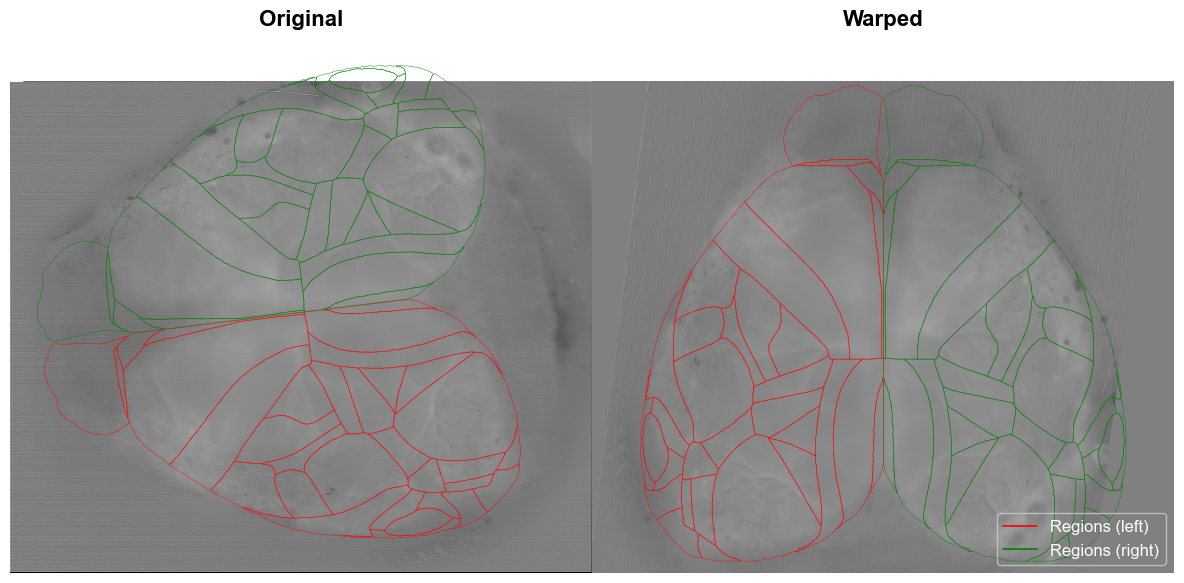

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot up to 20 spatial components (or fewer if U has fewer)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# --- image (left: original, right: warped) ---
U0 = stack.originalU[:, :, 0]
Uw0 = stack.U_warped[:, :, 0]
H, W = U0.shape

img = np.concatenate([U0, Uw0], axis=1)

ax.imshow(img, vmin=-0.01, vmax=0.01, cmap="gray")

# Titles in axes coordinates (robust to data limits)
ax.text(
    0.25, 1.02, "Original",
    transform=ax.transAxes,
    ha="center", va="bottom",
    fontsize=16, color="black", weight="bold",
    clip_on=False,
)
ax.text(
    0.75, 1.02, "Warped",
    transform=ax.transAxes,
    ha="center", va="bottom",
    fontsize=16, color="black", weight="bold",
    clip_on=False,
)

# Overlay regions in warped space (left half)
for _, r in ibl_ccf_regions["ccf_regions_target"][:].iterrows():
    ax.plot(r["left_x"], r["left_y"], color="red", lw=0.3)
    ax.plot(r["right_x"], r["right_y"], color="green", lw=0.3)

# Overlay regions in original/reference space (right half) with x-offset
# plot the raw reference because the images were converted
for _, r in ibl_ccf_regions["ccf_regions_source"][:].iterrows():
    ax.plot(np.array(r['left_x'])+stack.U.shape[1],r['left_y'],'red',lw=0.3)
    ax.plot(np.array(r['right_x'])+stack.U.shape[1],r['right_y'],'green',lw=0.3)

 # --- legend (two entries) ---
legend_handles = [
    Line2D([0], [0], color="red", lw=1.2, label="Regions (left)"),
    Line2D([0], [0], color="green", lw=1.2, label="Regions (right)"),
]

ax.legend(handles=legend_handles, loc="lower right", frameon=True)

# Hide unused subplots if fewer than 20 components
ax.axis("off")
plt.tight_layout()

plt.show()